In [1]:
#
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Users/charlieturner/Documents/CountingBoats
Date range: 2016-07-23 00:00:00 2024-06-24 00:00:00
Number of days: 2894
Days we have: 451
Missing days: 2443


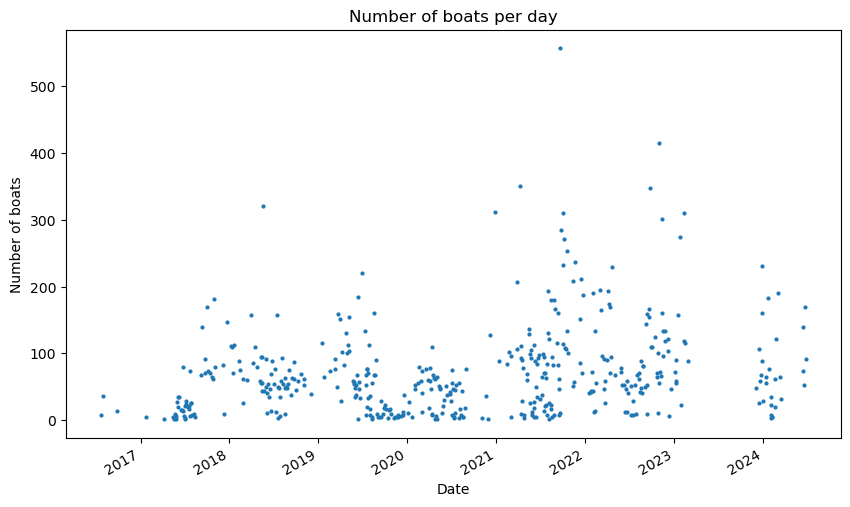

In [2]:
%cd /Users/charlieturner/Documents/CountingBoats
from counting_boats.utils.area_coverage import is_inside
from counting_boats.utils.planet_utils import get_aois

aois = [
    ('peel', 'data/polygons/peel.json'),
    ('tangalooma', 'data/polygons/tangalooma.json'),
    ('south_bribie', 'data/polygons/south_bribie.json')
]


# load the data
data1 = pd.read_csv("visualisation/data/alex_boats.csv")
data1['date'] = pd.to_datetime(data1['date'], dayfirst=True)

data2 = pd.read_csv("visualisation/data/boat_counts_23_24.csv")
data2['date'] = pd.to_datetime(data2['date'], dayfirst=True)

data3 = pd.read_csv("visualisation/data/boat_counts_24.csv")
data3['date'] = pd.to_datetime(data3['date'], dayfirst=True)

data = pd.concat([data1, data2, data3]).sort_values('date').reset_index(drop=True)

data = data[data['AOI'] != 'unknown']

print("Date range:", data['date'].min(), data['date'].max())
date_range = pd.date_range(data['date'].min(), data['date'].max())
print("Number of days:" , len(date_range))
print("Days we have:", len(pd.unique(data['date'])))
# print the number of missing dates within that range
missing_dates = date_range[~date_range.isin(data['date'])]
print("Missing days:", len(missing_dates))

counts = data.groupby('date').size()

# plot the number of boats per day (marker size 5)
ax = counts.plot(x='date', y='count', style='o', figsize=(10, 6), markersize=2)
ax.set_xlabel("Date")
ax.set_ylabel("Number of boats")
ax.set_title("Number of boats per day")
plt.show()

In [3]:
data.head()

,date,class,latitude,longitude,confidence,AOI,images,w,h
0,2016-07-23,0.0,-27.029093,153.099683,0.602136,southBribie,NaN,NaN,NaN
1,2016-07-23,0.0,-27.043734,153.131123,0.782813,southBribie,NaN,NaN,NaN
2,2016-07-23,0.0,-27.073810,153.147421,0.690460,southBribie,NaN,NaN,NaN
3,2016-07-23,0.0,-27.069445,153.138789,0.832270,southBribie,NaN,NaN,NaN
4,2016-07-23,0.0,-27.028120,153.097550,0.746432,southBribie,NaN,NaN,NaN


/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


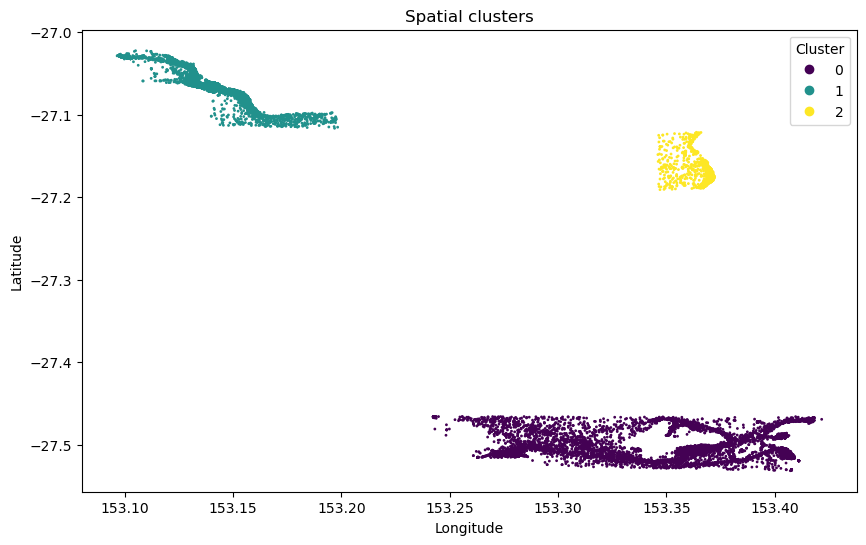

,date,class,latitude,longitude,confidence,AOI,images,w,h,cluster
0,2016-07-23,0.0,-27.029093,153.099683,0.602136,south_bribie,NaN,NaN,NaN,1
1,2016-07-23,0.0,-27.043734,153.131123,0.782813,south_bribie,NaN,NaN,NaN,1
2,2016-07-23,0.0,-27.073810,153.147421,0.690460,south_bribie,NaN,NaN,NaN,1
3,2016-07-23,0.0,-27.069445,153.138789,0.832270,south_bribie,NaN,NaN,NaN,1
4,2016-07-23,0.0,-27.028120,153.097550,0.746432,south_bribie,NaN,NaN,NaN,1


In [4]:
# break the data spatially into 3 clusters (ignoring AOIS)

X = data[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
data['cluster'] = kmeans.labels_
# get rid of the outliers (great barrier reef)
data = data[data['cluster'] == 0]

# now cluster again with 3 clusters
X = data[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data['cluster'] = kmeans.labels_

# plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['longitude'], data['latitude'], c=data['cluster'], s=1)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial clusters")
plt.show()

# north-most cluster is south_bribie
# south-most cluster is peel
# middle cluster is tangalooma

# assign the AOI to each cluster
data.loc[data['cluster'] == 0, 'AOI'] = 'peel'
data.loc[data['cluster'] == 1, 'AOI'] = 'south_bribie'
data.loc[data['cluster'] == 2, 'AOI'] = 'tangalooma'

data.head()



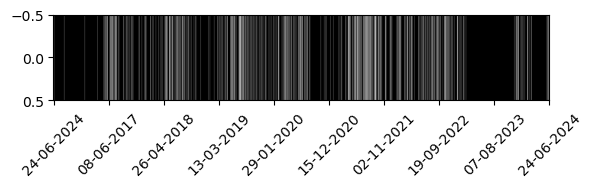

In [5]:
# Visualise the missing dates
dates_we_have = data['date'].value_counts().sort_index()
mask = np.isin(date_range, dates_we_have.index)
mask = mask.reshape(1, -1)
# visualise the mask 
fig, ax = plt.subplots()
ax.imshow(mask, aspect=500, cmap='gray')
x = np.linspace(0, len(date_range), 10)
ax.set_xticks(x)
ax.set_xticklabels([date_range[int(i-1)].strftime("%d-%m-%Y") for i in x], rotation=45)

plt.show()

In [6]:
# Biggest run of consecutive dates we have
consecutive_dates = np.diff(np.where(np.diff(np.where(mask == 0)) == 1))
print("Longest run of consecutive dates we have:", consecutive_dates.max())

Longest run of consecutive dates we have: 6


## Visualise some data spatially

In [7]:
# work out some limits
x_min = data['longitude'].min()
x_max = data['longitude'].max()
y_min = data['latitude'].min()
y_max = data['latitude'].max()

# add a 5% margin to the limits
x_margin = 0.05 * (x_max - x_min)
y_margin = 0.05 * (y_max - y_min)
x_min -= x_margin
x_max += x_margin
y_min -= y_margin
y_max += y_margin

print(x_min, x_max, y_min, y_max)


153.08023391676807 153.43790584485376 -27.557192707068122 -26.99721188145715


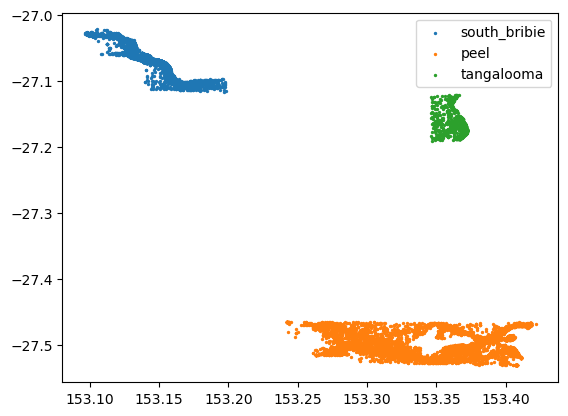

In [8]:

# plot all the boats
fig, ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
for aoi in data['AOI'].unique():
    aoi_data = data[data['AOI'] == aoi]
    ax.scatter(aoi_data['longitude'], aoi_data['latitude'], label=aoi, s=2)
ax.legend()
plt.show()

# *******************************
# This works but takes time
# *******************************

# Do an animation through the days boats
# import matplotlib.animation as animation
# fig, ax = plt.subplots()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# sc = ax.scatter([], [])
# def update(day):
#     day_data = data[data['date'] == dates_we_have.index[day]]
#     sc.set_offsets(day_data[['longitude', 'latitude']])
#     # set the title to the date
#     ax.set_title(dates_we_have.index[day])
#     return sc,
# ani = animation.FuncAnimation(fig, update, frames=len(dates_we_have), interval=100)

# ani.save('data/boat_animation.mp4', writer='ffmpeg', fps=4)


We have 19759 entries over 216 days for peel
2016-09-26 00:00:00 2024-06-24 00:00:00
day_of_week
0    1758
1    1645
2    2078
3    2169
4    3880
5    4100
6    4129
Name: count, dtype: int64


/var/folders/8m/ly22v28n5c95xl76kl22fczh0000gn/T/ipykernel_2142/3323270349.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi_data['day_of_week'] = aoi_data['date'].dt.dayofweek


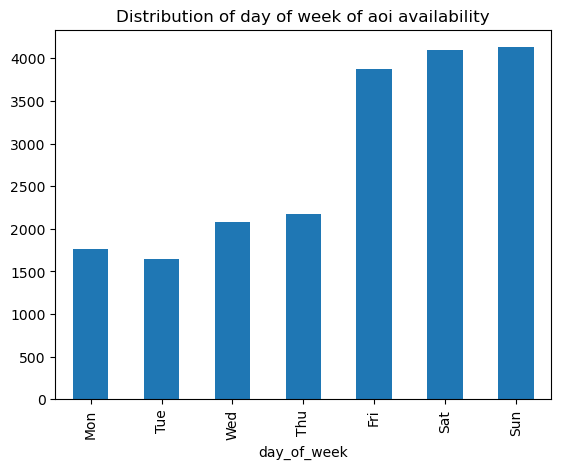

In [9]:
# Peel island is just all entries with AOI = peelIsland
AOI = 'peel'
aoi_data = data[data['AOI'] == AOI]
print("We have {} entries over {} days for {}".format(len(aoi_data), len(pd.unique(aoi_data['date'])), AOI))
aoi_data.head()
# print the range of dates we have
print(aoi_data['date'].min(), aoi_data['date'].max())


# distribution of day of week
aoi_data['day_of_week'] = aoi_data['date'].dt.dayofweek
day_of_week = aoi_data['day_of_week'].value_counts().sort_index()
# normalise based on the number of days we have
print(day_of_week)
fig, ax = plt.subplots()
day_of_week.plot(kind='bar', ax=ax)
ax.title.set_text('Distribution of day of week of aoi availability')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


In [10]:
# Load the weather data
weather = pd.read_csv("visualisation/data/weather.csv")
# convert the date to a datetime
weather['date'] = pd.to_datetime(weather['YYYY-MM-DD'])
weather = weather.drop(columns=['YYYY-MM-DD', 'metadata'])
weather.head()


,latitude,longitude,daily_rain,daily_rain_source,max_temp,max_temp_source,min_temp,min_temp_source,date
0,-27.5,153.3,0.1,25,27.9,25,20.2,25,2023-01-01
1,-27.5,153.3,0.1,25,28.3,25,19.6,25,2023-01-02
2,-27.5,153.3,0.0,25,28.6,25,18.4,25,2023-01-03
3,-27.5,153.3,0.0,25,30.3,25,20.7,25,2023-01-04
4,-27.5,153.3,4.2,25,26.8,25,21.8,25,2023-01-05


# Interpolation

In [11]:
# Build the dataset for machine learning:
# Put together the weather and boat data, lets start with count per day
# First dataset: date, count, daily_rain, max_temp, min_temp 

peel_grouped = aoi_data.groupby('date')
peel_counts = peel_grouped.size()
peel_counts = peel_counts.reset_index()
peel_counts.columns = ['date', 'count']

weather_columns = ['date', 'daily_rain', 'max_temp', 'min_temp']
weather = weather[weather_columns]

data = pd.merge(peel_counts, weather, on='date', how='inner')
data['day_of_week'] = data['date'].dt.dayofweek
data['season'] = (data['date'].dt.month % 12 + 3) // 3
data['year'] = data['date'].dt.year
# one hot encode the date data
data = pd.get_dummies(data, columns=['day_of_week', 'season', 'year'], drop_first=True, dtype=int)
print("Observations:", data.shape[0])

# normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['daily_rain', 'max_temp', 'min_temp']] = scaler.fit_transform(data[['daily_rain', 'max_temp', 'min_temp']])

data.head()

Observations: 24


,date,count,daily_rain,max_temp,min_temp,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,season_2,season_3,year_2024
0,2023-01-06,72,0.079038,0.700935,0.670968,0,0,0,1,0,0,0,0,0
1,2023-01-18,94,0.013746,0.747664,0.703226,0,1,0,0,0,0,0,0,0
2,2023-01-25,275,1.000000,0.822430,0.767742,0,1,0,0,0,0,0,0,0
3,2023-02-10,95,0.010309,0.831776,0.735484,0,0,0,1,0,0,0,0,0
4,2023-02-11,180,0.000000,0.971963,0.716129,0,0,0,0,1,0,0,0,0


Error: 136.91698956246498


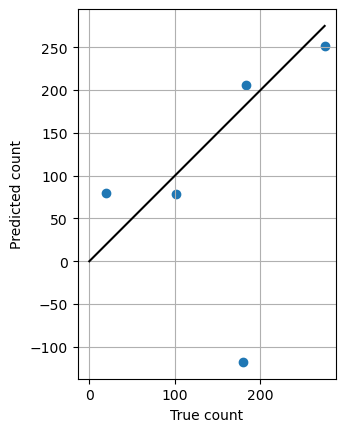

Error: 38.40187173778815


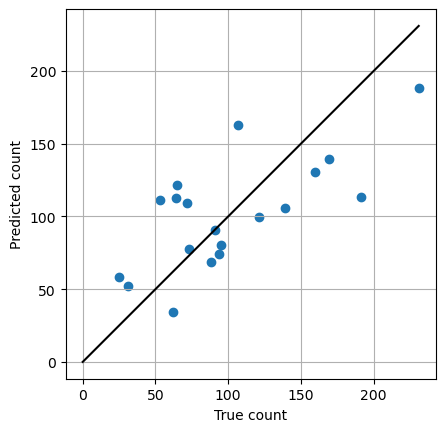

In [12]:
# Now we can build a simple linear regression model to predict the count of boats

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

x_cols = [col for col in data.columns if col not in ['date', 'count']]

X = data[x_cols]

y = data['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)
print("Error:", err)

# plot the predictions
def plot_predictions(y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.set_xlabel('True count')
    ax.set_ylabel('Predicted count')
    # grid
    ax.grid(True)
    # add the line y = x
    ax.plot([0, y_test.max()], [0, y_test.max()], color='black')
    # make the aspect ratio equal
    ax.set_aspect('equal', adjustable='box')
    plt.show()

plot_predictions(y_test, y_pred)

# plot predictions for the training data
y_pred_train = model.predict(X_train)

Err = rmse(y_train, y_pred_train)
print("Error:", Err)

plot_predictions(y_train, y_pred_train)




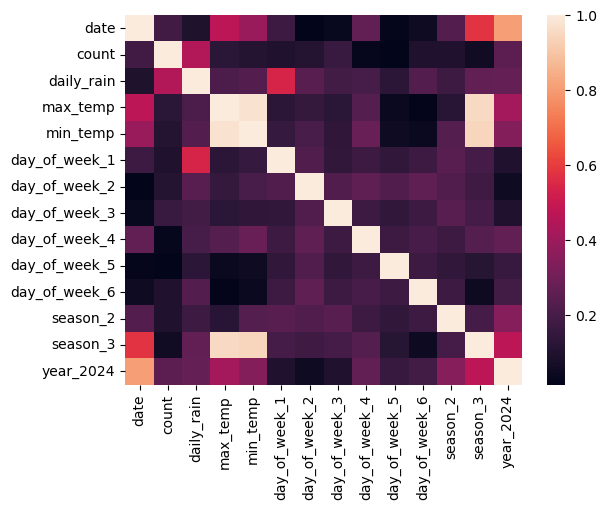

In [13]:
# Plot a heatmap of the correlation matrix
import seaborn as sns
corr = data.corr()
fig, ax = plt.subplots()
sns.heatmap(corr.abs(), ax=ax)
plt.show()


In [14]:
# Try a more complex model like RF
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)

print("Test Error RMSE:", err)

# plot the predictions

# plot_predictions(y_test, y_pred)
y_pred_train = model.predict(X_train)
Err = rmse(y_train, y_pred_train)
print("Train Error RMSE:", Err)




Test Error RMSE: 86.4645423280549
Train Error RMSE: 26.134878389253174


In [15]:
# Try a neural network
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(32, 64, 128, 256, 128, 64, 32), random_state=42, max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)
print("Test Error RMSE:", err)
y_train_pred = model.predict(X_train)
Err = rmse(y_train, y_train_pred)
print("Train Error RMSE:", Err)
# plot_predictions(y_test, y_pred)

Test Error RMSE: 101.98398095189097
Train Error RMSE: 1.318310013466121


False
=== Epoch   15000 loss: 0.000 val_loss: 9524.420 Best val_loss: 7542.751 at epoch    5079 =====
Stopping early at epoch 15080

Validation Error RMSE: 86.849014


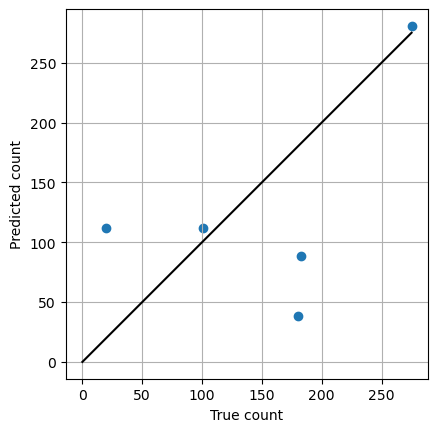

Training Error RMSE: 29.349834


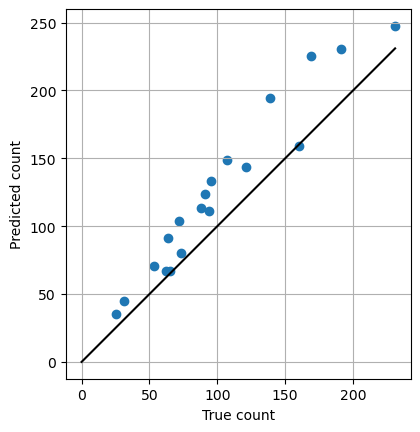

In [16]:
# Try a simple fully connected neural network
import torch

class BoatModel(torch.nn.Module):
    def __init__(self, input_size):
        super(BoatModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 128)
        self.fc3 = torch.nn.Linear(128, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 64)
        self.fc6 = torch.nn.Linear(64, 32)
        self.fc7 = torch.nn.Linear(32, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

class VarPenalisedMSELoss(torch.nn.Module):
    def __init__(self, penalty=0.1):
        super(VarPenalisedMSELoss, self).__init__()
        self.penalty = penalty
    def forward(self, y_pred, y_true):
        loss = torch.mean((y_pred - y_true) ** 2)
        var = torch.var(y_pred)
        return loss + self.penalty * var
    

model = BoatModel(X_train.shape[1])
criterion = VarPenalisedMSELoss(penalty=0)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

# oversample high y values to balance the dataset 
y_bins = np.linspace(y_train.min(), y_train.max(), 10)
count = np.histogram(y_train, bins=y_bins)[0]
weights = 1 / (count+1)
sample_weights = weights[(np.digitize(y_train-1, y_bins) - 1)]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(y_train), replacement=True)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=round(X_train.shape[0]/2),
                                           sampler=sampler)


X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

best_after = 1000
best_epoch = 0
best_val_loss = np.inf
best_model = None

losses = []
val_losses = []

# print out if torch is using mps
print(torch.cuda.is_available())

for epoch in range(100000):
    optimizer.zero_grad()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
        if epoch % 1000 == 0:
            print(f"=== Epoch {epoch:7} loss: {loss.item():4.3f} val_loss: {val_loss.item():4.3f} Best val_loss: {best_val_loss:4.3f} at epoch {best_epoch:7} ===", end="\r")
        losses.append(loss.item())
        val_losses.append(val_loss.item())
        if val_loss < best_val_loss and epoch > best_after:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = BoatModel(X_train.shape[1])
            best_model.load_state_dict(model.state_dict())
        if epoch - best_epoch > 10000:
            print(f"\nStopping early at epoch {epoch}")
            break
print()


y_pred = best_model(X_test_tensor)
err = rmse(y_test_tensor.detach().numpy(), y_pred.detach().numpy())
print("Validation Error RMSE:", err)

plot_predictions(y_test_tensor.detach().numpy(), y_pred.detach().numpy())

# plot predictions over training data
y_pred = best_model(X_train_tensor)
err = rmse(y_train_tensor.detach().numpy(), y_pred.detach().numpy())
print("Training Error RMSE:", err)

plot_predictions(y_train_tensor.detach().numpy(), y_pred.detach().numpy())

In [17]:
# Use ARIMA to estimate the number of boats on any given day. 
# Then -> Use a spatial density model to predict where those boats are likely to be.

# Essentially what we want is:
# Overall: A good estimate for the number of boats within each small region of the bay on any given day.
# To achieve this we need:
#   A model that can predict the number of boats in a given area on a given day
#   A model that can determine the spatial distribution of those boats
#   Either/both of these models may take into account any factors such as:
#   - Weather
#   - Day of week
#   - Season
#   - Spatial distribution of boats on previous days
#   - Spatial distribution of boats in other areas on the same day

!pwd
%cd ./visualisation

/Users/charlieturner/Documents/CountingBoats
/Users/charlieturner/Documents/CountingBoats/visualisation


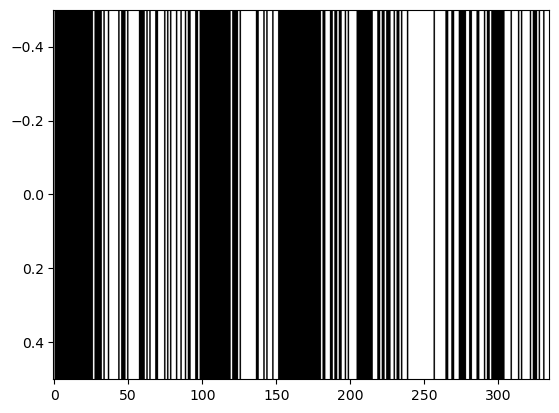

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0]


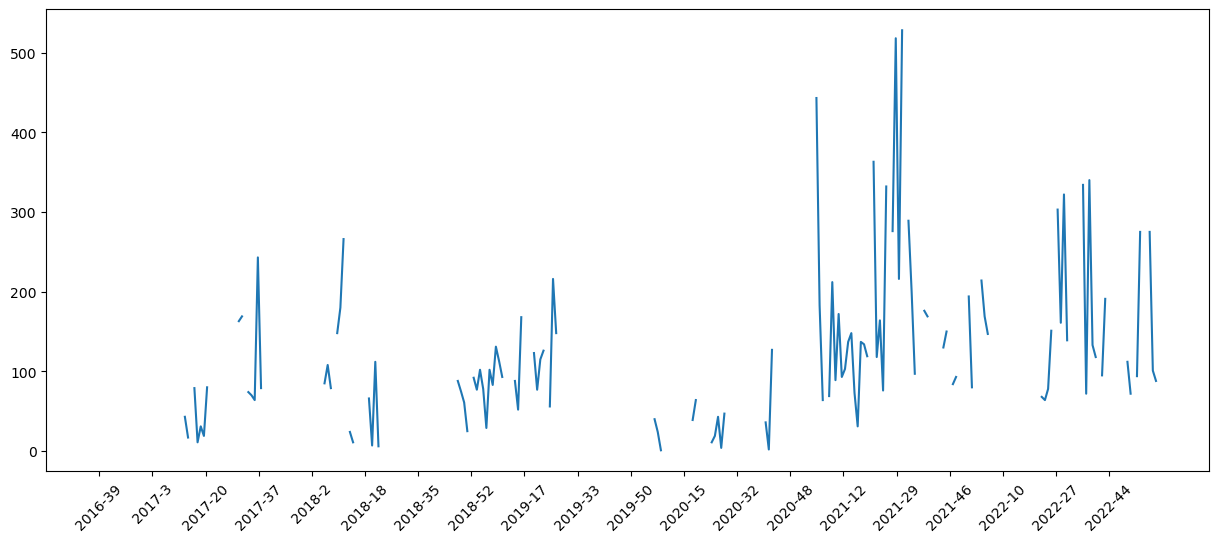

In [18]:
# Try with STARIMA
from pysal.lib import weights
from statsmodels.tsa.arima.model import ARIMA

# build the dataset
data1 = pd.read_csv("data/alex_boats.csv")
data1.loc['date'] = pd.to_datetime(data1['date'], dayfirst=True)
data = data1.copy()[data1['AOI'] == 'peelIsland']
# sort by date
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data = data.sort_values('date').reset_index(drop=True)
data['week'] = data['date'].dt.isocalendar().week
data['year_week'] = data['date'].dt.year.astype(str) + '-' + data['week'].astype(str)
data['season'] = (data['date'].dt.month % 12 + 3) // 3
# make season one hot encoded
data = pd.get_dummies(data, columns=['season'], drop_first=True, dtype=int)
data = data.sort_values('year_week').reset_index(drop=True)
# We have data, class, latitude, longitude, confidence, AOI
# ignore confidence and AOI. We want to do STARIMA on the number of boats w

# spatial weight matrix
coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
w = weights.DistanceBand.from_array(coords, threshold=1) #TODO: understand this

# convert lat/long into locations (grid). Lets do a 10x10 grid
grid = 10
lat_range = data['latitude'].max() - data['latitude'].min()
long_range = data['longitude'].max() - data['longitude'].min()
data['x'] = ((data['longitude'] - data['longitude'].min()) / long_range * grid).astype(int) 
data['y'] = ((data['latitude'] - data['latitude'].min()) / lat_range * grid).astype(int)
data['location'] = data['x'] + (data['y'] * 10)

# group by location and date, with the number of boats as the value
data_grouped = data.groupby(['year_week', 'location']).size().reset_index()
data_grouped.columns = ['year_week', 'location', 'value']
data_wide = data_grouped.pivot(index='year_week', columns='location', values='value')#.fillna(0)
# data_wide.index = pd.to_datetime(data_wide.index, dayfirst=True)
# sort data_wide by date
data_wide = data_wide.sort_index()
# print(data_wide.head())
all_weeks = pd.date_range(data['date'].min(), data['date'].max(), freq='W')
all_year_weeks = [str(date.year) + '-' + str(date.isocalendar().week) for date in all_weeks]
week_has_counts = [week in data_wide.index for week in all_year_weeks]
plt.imshow(np.array(week_has_counts).reshape(1, -1), cmap='gray', aspect='auto')
plt.show()

data_with_missing = data_wide.copy()
data_with_missing = data_with_missing.reindex(all_year_weeks)
# make sure the columns are 1-100, with 0 on any that didn't exist before
for i in range(1, 100):
    if i not in data_with_missing.columns:
        data_with_missing[i] = 0
# sort columns
data_with_missing = data_with_missing.sort_index(axis=1)
# if any nan values in row, fill whole row with -1
data_with_missing = data_with_missing.apply(lambda x: x.fillna(-1) if x.isnull().all() else x, axis=1)
data_with_missing = data_with_missing.apply(lambda x: x.fillna(0) if not x.isnull().all() else x, axis=1)
print(list(data_with_missing.loc[data_with_missing.index[0], :]))
# data_with_missing = data_with_missing
data_with_missing = data_with_missing.sort_index()
plt.figure(figsize=(15, 6))
plt.plot(data_with_missing.sum(axis=1).replace(0, np.nan))
xticks = np.linspace(0, len(data_with_missing), 20, endpoint=False)
plt.xticks(xticks, [all_year_weeks[int(x)] for x in xticks], rotation=45)
plt.xticks(rotation=45)
plt.show()

In [19]:

# fit ARIMA model for each location
models = {}
for loc in data_wide.columns:
    model = ARIMA(data_wide[loc], order=(1, 1, 1))
    models[loc] = model.fit()

# combine results and predict
predictions = pd.DataFrame(index=data_wide.index, columns=data_wide.columns)
for loc in data_wide.columns:
    predictions[loc] = models[loc].predict()


/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/charlieturner/miniforge3/envs/boats/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: Value

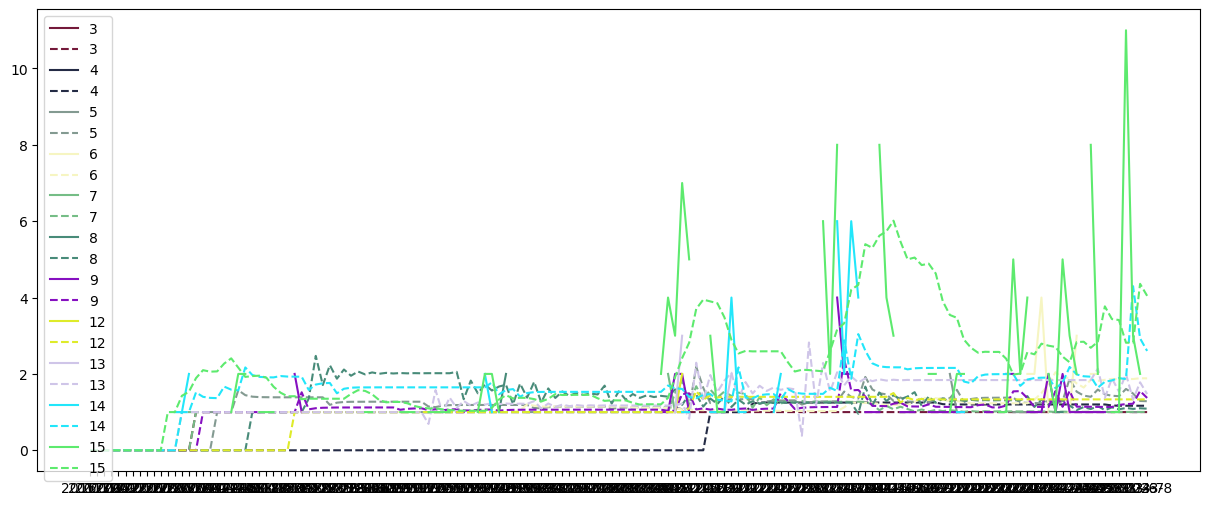

[0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [20]:

import math
# plot the predictions
fig, ax = plt.subplots(figsize=(15, 6))
id  = 0
errors = np.zeros(len(data_wide.columns))
for loc in data_wide.columns:
    exists_mask = ~data_wide[loc].isna()
    if exists_mask.sum() == 0:
        print(f"Location {loc} has no data")
        continue
    errors[id] = math.sqrt(mean_squared_error(data_wide[loc][exists_mask], predictions[loc][exists_mask]))

colors = np.random.rand(len(data_wide.columns), 3)

for loc in data_wide.columns:
    ax.plot(data_wide.index, data_wide[loc], label=loc, color=tuple(colors[id]))  # actual: solid
    ax.plot(data_wide.index, predictions[loc], label=loc, linestyle='--', color=colors[id])  # predicted: dashed
    id += 1
    if id > 10:
        break
ax.legend(loc='upper left')
plt.show()
print(errors)





In [21]:
# Try a similar thing, but using an AutoEncoder
# Method: 
#   - Train an autoencoder to take the grid of data and weather/any other features, and output the grid of data
#   - Can then use the autoencoder to predict the grid, given only the weather/any other features, or partial grid data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class TemporalGridDataset(Dataset):
    def __init__(self, grids, features, seq_length):
        self.grids = grids
        self.features = features
        self.seq_length = seq_length

    def __len__(self):
        return len(self.grids) - self.seq_length + 1

    def __getitem__(self, idx):
        grids_seq = self.grids[idx:idx + self.seq_length]
        features_seq = self.features[idx:idx + self.seq_length]
        return grids_seq, features_seq

class LSTMAutoEncoder(nn.Module):
    def __init__(self, grid_dim, feature_dim, hidden_dim, seq_length):
        super(LSTMAutoEncoder, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.grid_dim = grid_dim

        # LSTM Encoder
        self.lstm_encoder = nn.LSTM(input_size=grid_dim + feature_dim, hidden_size=hidden_dim, batch_first=True)
        # LSTM Decoder
        self.lstm_decoder = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, grid_dim)
        self.relu = nn.ReLU()

    def forward(self, grids, features):
        batch_size = grids.size(0)
        
        # Concatenate grids and features
        x = torch.cat((grids.float(), features.float()), dim=2 )

        # LSTM Encoder
        _, (hidden, _) = self.lstm_encoder(x)

        # Repeat the hidden state for each time step in the sequence for the decoder
        decoder_input = hidden.repeat(self.seq_length, 1, 1).permute(1, 0, 2)

        # LSTM Decoder
        decoder_output, _ = self.lstm_decoder(decoder_input)

        # Apply fully connected layers to the output of the LSTM Decoder
        decoded = self.relu(self.fc1(decoder_output))
        decoded = self.fc2(decoded)

        return decoded



In [27]:

# Get data

boats = pd.read_csv("data/boat_detections.csv")
boats['date'] = pd.to_datetime(boats['date'], dayfirst=True)
date_range = pd.date_range(boats['date'].min(), boats['date'].max())
all_dates = pd.DataFrame(date_range, columns=['date'])
boats = all_dates.merge(boats, on='date', how='right')
print(boats)


weather =  pd.read_csv("data/weather.csv")
weather['date'] = pd.to_datetime(weather['YYYY-MM-DD'])

# Get the data in the right format
data = boats.merge(weather[['date', 'daily_rain', 'max_temp']], on='date', how='inner')
print(data.head())
# do the grids
long_range = data['longitude'].max() - data['longitude'].min()
lat_range = data['latitude'].max() - data['latitude'].min()
grid = 10
data['x'] = ((data['longitude'] - data['longitude'].min()) / long_range * grid).astype(int)
data['y'] = ((data['latitude'] - data['latitude'].min()) / lat_range * grid).astype(int)
data['location'] = data['x'] + (data['y'] * 10)
data_grouped = data.groupby(['date', 'location']).size().reset_index()
print(data_grouped.head())
data_grouped.columns = ['date', 'location', 'value']
data_wide = data_grouped.pivot(index='date', columns='location', values='value')
data_wide = data_wide.fillna(-1) # -1 for unknown

grids = data_wide.values
features = data[['daily_rain', 'max_temp']].values

seq_length = 7  # Sequence length (e.g., one week)
grid_size = grids.shape[1] # max 100 (some are empty in all data so less)
feature_dim =  features.shape[1] # Rain, max temp, season of year * 3
hidden_dim = 128




# Create DataLoader
dataset = TemporalGridDataset(grids, features, seq_length)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# train test split 0.8
train_grids = np.zeros((int(len(grids) * 0.8), grid_size))
train_features = np.zeros((int(len(grids) * 0.8), feature_dim))
test_grids = np.zeros((len(grids) - int(len(grids) * 0.8), grid_size))
test_features = np.zeros((len(grids) - int(len(grids) * 0.8), feature_dim))

i = 0
for batch_grids, batch_features in dataloader:
    if i < int(len(grids) * 0.8):
        train_grids[i] = batch_grids[0, 0, :].numpy()
        train_features[i] = batch_features[0, 0, :].numpy()
    else:
        test_grids[i - int(len(grids) * 0.8)] = batch_grids[0, 0, :].numpy()
        test_features[i - int(len(grids) * 0.8)] = batch_features[0, 0, :].numpy()
    i += 1

print (train_grids.shape, train_features.shape, test_grids.shape, test_features.shape)
dataset = TemporalGridDataset(train_grids, train_features, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = TemporalGridDataset(test_grids, test_features, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMAutoEncoder(grid_dim=grid_size, feature_dim=feature_dim, hidden_dim=hidden_dim, seq_length=seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
save_best_after = 50
best_val_loss = np.inf
best_model = None
best_epoch = 0
num_epochs = 2000

for epoch in range(num_epochs):
    for batch_grids, batch_features in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_grids, batch_features)
        loss = criterion(outputs, batch_grids.float())
        loss.backward()
        optimizer.step()
        # test
        if epoch > save_best_after:
            with torch.no_grad():
                for test_grids, test_features in test_dataloader:
                    test_outputs = model(test_grids, test_features)
                    test_loss = criterion(test_outputs, test_grids.float())
                    if test_loss < best_val_loss:
                        best_epoch = epoch
                        best_val_loss = test_loss
                        best_model = LSTMAutoEncoder(grid_dim=grid_size, feature_dim=feature_dim, hidden_dim=hidden_dim, seq_length=seq_length)
                        best_model.load_state_dict(model.state_dict())

            
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {test_loss.item():.4f}', end='\r')
print()

print("Training complete!")
print(f"Best Validation Loss: {best_val_loss.item():.4f} at epoch {best_epoch}")

# predict on test data
grid, feature = next(iter(test_dataloader))
output = best_model(grid, feature)
# imshow the predictions, but: remember that the columns of the prediction 
# are not 1-100. Have to fill in missing columns with 0
output = output.squeeze().detach().numpy()
output = output.reshape((seq_length, 10, 10))
output = output[-1, :, :]
plt.imshow(output)




# print out the model architecture
print(model)


           date  class             images   latitude   longitude  confidence  \
0    2024-06-19      0  20240619_peel.tif -27.508620  153.276005    0.905089   
1    2024-06-19      0  20240619_peel.tif -27.513711  153.272012    0.902066   
2    2024-06-19      0  20240619_peel.tif -27.513664  153.272834    0.883516   
3    2024-06-19      0  20240619_peel.tif -27.513234  153.271241    0.900639   
4    2024-06-19      0  20240619_peel.tif -27.512059  153.274184    0.743140   
...         ...    ...                ...        ...         ...         ...   
2020 2024-07-11      1  20240711_peel.tif -27.497217  153.394587    0.919909   
2021 2024-07-11      1  20240711_peel.tif -27.482998  153.394445    0.838825   
2022 2024-07-11      1  20240711_peel.tif -27.487231  153.401445    0.562504   
2023 2024-07-11      1  20240711_peel.tif -27.472784  153.405400    0.876688   
2024 2024-07-11      1  20240711_peel.tif -27.509071  153.397606    0.935936   

              w          h   aoi  
0   

KeyboardInterrupt: 